# Riemannian Optimisation with Pymanopt for Inference in MoG models

The Mixture of Gaussians (MoG) model assumes that datapoints $\mathbf{x}_i\in\mathbb{R}^d$ follow a distribution described by the following probability density function:

$p(\mathbf{x}) = \sum_{m=1}^M \pi_m p_\mathcal{N}(\mathbf{x};\mathbf{\mu}_m,\mathbf{\Sigma}_m)$ where $\pi_m$ is the probability that the data point belongs to the $m^\text{th}$ mixture component and $p_\mathcal{N}(\mathbf{x};\mathbf{\mu}_m,\mathbf{\Sigma}_m)$ is the probability density function of a multivariate Gaussian distribution with mean $\mathbf{\mu}_m \in \mathbb{R}^d$ and psd covariance matrix $\mathbf{\Sigma}_m \in \{\mathbf{M}\in\mathbb{R}^{d\times d}: \mathbf{M}\succeq 0\}$.

As an example consider the mixture of three Gaussians with means
$\mathbf{\mu}_1 = \begin{bmatrix} -4 \\ 1 \end{bmatrix}$,
$\mathbf{\mu}_2 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$ and
$\mathbf{\mu}_3 = \begin{bmatrix} 2 \\ -1 \end{bmatrix}$, covariances
$\mathbf{\Sigma}_1 = \begin{bmatrix} 3 & 0 \\ 0 & 1 \end{bmatrix}$,
$\mathbf{\Sigma}_2 = \begin{bmatrix} 1 & 1 \\ 1 & 3 \end{bmatrix}$ and
$\mathbf{\Sigma}_3 = \begin{bmatrix} 0.5 & 0 \\ 0 & 0.5 \end{bmatrix}$
and mixture probability vector $\pi=\left[0.1, 0.6, 0.3\right]$.
Let's generate $N=1000$ samples of that MoG model and scatter plot the samples:

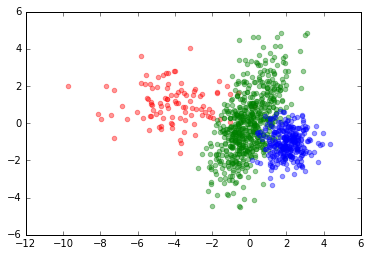

In [1]:
import autograd.numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
%matplotlib inline

# Number of data
N = 1000

# Dimension of data
D = 2

# Number of clusters
K = 3

pi = [0.1, 0.6, 0.3]
mu = [np.array([-4, 1]), np.array([0, 0]), np.array([2, -1])]
Sigma = [np.array([[3, 0],[0, 1]]), np.array([[1, 1.], [1, 3]]), .5 * np.eye(2)]

components = np.random.choice(K, size=N, p=pi)
samples = np.zeros((N, D))
# for each component, generate all needed samples
for k in range(K):
    # indices of current component in X
    indices = (k == components)
    # number of those occurrences
    n_k = indices.sum()
    if n_k > 0:
        samples[indices] = np.random.multivariate_normal(mu[k], Sigma[k], n_k)

colors = ['r', 'g', 'b', 'c', 'm']
for i in range(K):
    indices = (i == components)
    plt.scatter(samples[indices, 0], samples[indices, 1], alpha=.4, color=colors[i%K])
plt.axis('equal')
plt.show()

Given a data sample the de facto standard method to infer the parameters is the [expectation maximisation](https://en.wikipedia.org/wiki/Expectation-maximization_algorithm) (EM) algorithm that, in alternating so-called E and M steps, maximises the log-likelihood of the data.
In [arXiv:1506.07677](http://arxiv.org/pdf/1506.07677v1.pdf) Hosseini and Sra propose Riemannian optimisation as a powerful counterpart to EM. Importantly, they introduce a reparameterisation that leaves local optima of the log-likelihood unchanged while resulting in a geodesically convex optimisation problem over a product manifold $\prod_{m=1}^M\mathcal{PD}^{(d+1)\times(d+1)}$ of manifolds of $(d+1)\times(d+1)$ positive definite matrices.
The proposed method is on par with EM and shows less variability in running times.

The reparameterised optimisation problem for augmented data points $\mathbf{y}_i=[\mathbf{x}_i\ 1]$ can be stated as follows:

$$\min_{(S_1, ..., S_m, \nu_1, ..., \nu_{m-1}) \in \prod_{m=1}^M \mathcal{PD}^{(d+1)\times(d+1)}\times\mathbb{R}^{M-1}}
-\sum_{n=1}^N\log\left(
\sum_{m=1}^M \frac{\exp(\nu_m)}{\sum_{k=1}^M\exp(\nu_k)}
q_\mathcal{N}(\mathbf{y}_n;\mathbf{S}_m)
\right)$$

where

* $\mathcal{PD}^{(d+1)\times(d+1)}$ is the manifold of positive definite
$(d+1)\times(d+1)$ matrices
* $\mathcal{\nu}_m = \log\left(\frac{\alpha_m}{\alpha_M}\right), \ m=1, ..., M-1$ and $\nu_M=0$
* $q_\mathcal{N}(\mathbf{y}_n;\mathbf{S}_m) =
2\pi\exp\left(\frac{1}{2}\right)
|\operatorname{det}(\mathbf{S}_m)|^{-\frac{1}{2}}(2\pi)^{-\frac{d+1}{2}}
\exp\left(-\frac{1}{2}\mathbf{y}_i^\top\mathbf{S}_m^{-1}\mathbf{y}_i\right)$

**Optimisation problems like this can easily be solved using Pymanopt – even without the need to differentiate the cost function manually!**

So let's infer the parameters of our toy example by Riemannian optimisation using Pymanopt:

In [2]:
import autograd.numpy as np
from autograd.scipy.misc import logsumexp
from pymanopt.manifolds import Product, Euclidean, PositiveDefinite
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent

# (1) Instantiate the manifold
manifold = Product([PositiveDefinite(D+1, k=K), Euclidean(2)])

# (2) Define cost function
# The parameters must be contained in a list theta.
def cost(theta):
    # Unpack parameters
    nu = np.hstack([theta[1], [0]])
    
    S = theta[0]
    logdetS = np.expand_dims(np.linalg.slogdet(S)[1], 1)
    y = np.vstack([samples.T, np.ones((1, N))])

    # Calculate log_q
    y = np.expand_dims(y, 0)
    
    # 'Probability' of y belonging to each cluster
    log_q = -0.5 * (np.sum(y * np.linalg.solve(S, y), axis=1) + logdetS)

    alpha = np.exp(nu)
    alpha = alpha / np.sum(alpha)
    alpha = np.expand_dims(alpha, 1)
    
    loglikvec = logsumexp(np.log(alpha) + log_q, axis=0)
    return -np.sum(loglikvec)

problem = Problem(manifold=manifold, cost=cost, verbosity=1)

# (3) Instantiate a Pymanopt solver
solver = SteepestDescent()

# let Pymanopt do the rest
Xopt = solver.solve(problem)

Couldn't import dot_parser, loading of dot files will not be possible.
Computing gradient of cost function...
Terminated - min stepsize reached after 203 iterations, 1.09 seconds.



Once Pymanopt has finished the optimisation we can obtain the inferred parameters as follows:

In [3]:
mu1hat = Xopt[0][0][0:2,2:3]
Sigma1hat = Xopt[0][0][:2, :2] - mu1hat.dot(mu1hat.T)
mu2hat = Xopt[0][1][0:2,2:3]
Sigma2hat = Xopt[0][1][:2, :2] - mu2hat.dot(mu2hat.T)
mu3hat = Xopt[0][2][0:2,2:3]
Sigma3hat = Xopt[0][2][:2, :2] - mu3hat.dot(mu3hat.T)
pihat = (np.exp(np.hstack([Xopt[1], [0]])) / 
      np.sum(np.exp(np.hstack([Xopt[1], [0]]))))

And convince ourselves that the inferred parameters are close to the ground truth parameters.

The ground truth parameters $\mathbf{\mu}_1, \mathbf{\Sigma}_1, \mathbf{\mu}_1, \mathbf{\Sigma}_2, \pi_1, \pi_2$:

In [4]:
print(mu[0])
print(Sigma[0])
print(mu[1])
print(Sigma[1])
print(mu[2])
print(Sigma[2])
print(pi[0])
print(pi[1])
print(pi[2])

[-4  1]
[[3 0]
 [0 1]]
[0 0]
[[ 1.  1.]
 [ 1.  3.]]
[ 2 -1]
[[ 0.5  0. ]
 [ 0.   0.5]]
0.1
0.6
0.3


And the inferred parameters $\hat{\mathbf{\mu}}_1, \hat{\mathbf{\Sigma}}_1, \hat{\mathbf{\mu}}_2, \hat{\mathbf{\Sigma}}_2, \hat{\pi}_1, \hat{\pi}_2$:

In [5]:
print(mu1hat)
print(Sigma1hat)
print(mu2hat)
print(Sigma2hat)
print(mu3hat)
print(Sigma3hat)
print(pihat[0])
print(pihat[1])
print(pihat[2])

[[-4.12]
 [ 1.  ]]
[[ 2.96 -0.21]
 [-0.21  1.07]]
[[-0.03]
 [-0.03]]
[[ 1.    0.9 ]
 [ 0.9   2.85]]
[[ 2.05]
 [-1.05]]
[[ 0.47  0.01]
 [ 0.01  0.49]]
0.0996490979008
0.603143937207
0.297206964892


Et voilà – this was a brief demonstration of how to do inference for MoG models by performing Manifold optimisation using Pymanopt.